<a href="https://colab.research.google.com/github/mugheesahmad/EuroSat-PyTorch/blob/master/EuroSat_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing** **Libraries**

In [0]:
#Importing Libraries
from skimage import io
import torch
from torchvision import models
import torchvision
import torch.nn as nn
import numpy as np
import random
from IPython.display import clear_output
import time
import os.path
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [0]:
EuroSat_Type = 'RGB'    # use 'RGB' or 'ALL' for type of Eurosat Dataset. Just change in this line. Rest of the code is managed for both type
lr = 0.01               # learn_rate
milestones = [50,75,90] # multistep scheduler
epochs = 100            # no of epochs

In [0]:
def iloader(path):
    image = np.asarray((io.imread(path))/32000,dtype='float32')
    return image.transpose(2,0,1)

In [0]:
def Load_data():
    if EuroSat_Type == 'RGB':
      data = torchvision.datasets.DatasetFolder(root=root,loader = iloader, transform=None, extensions = 'jpg')
    elif EuroSat_Type == 'ALL':
      data = torchvision.datasets.DatasetFolder(root=root,loader = iloader, transform=None, extensions = 'tif')
    train_set, val_set = train_test_split(data, test_size=0.2, stratify=data.targets)
    #print(np.unique(train_set, return_counts=True))  #uncomment for class IDs
    #print(np.unique(val_set, return_counts=True))    #uncomment for class IDs
      
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=3, drop_last = True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=True, num_workers=0, drop_last = True)
    #test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True, num_workers=0, drop_last = True)
    return train_loader, val_loader #,test_loader

**Functions for Augmentation**

In [0]:
def get_random_pos(img, window_shape = [55,55] ):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    #x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    #y2 = y1 + h
    return x1, x1 + w, y1, y1 + h #x1, x2, y1, y2

def random_crop_area(img):
    x1,x2,y1,y2 = get_random_pos(img)
    Sen_Im = img[:, x1:x2,y1:y2]
    return resize(Sen_Im,img.shape,anti_aliasing=True)

def sigmoid(z):
    return 1/(1+np.exp(-z))

def cus_aug(data):
    data = torch.rot90(data,random.randint(-3,3), dims=random.choice([[3,2],[2,3]]))
    if random.random()>0.75:
        data = torch.flip(data, dims = random.choice([[2,],[3,],[2,3]]))
    pixmis = torch.empty_like(data).random_(data.shape[-1])
    pixmis = torch.where(pixmis>(data.shape[-1]/8),torch.ones_like(data),torch.zeros_like(data))
    return data* pixmis

In [0]:
def Load_model():
    model_ft = models.resnet50()#pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, 10)
    if EuroSat_Type == 'RGB':
      inBands = 3
    elif EuroSat_Type == 'ALL':
      inBands = 13
    model_ft.conv1 = nn.Conv2d(inBands, 64, kernel_size=7, stride=2, padding = 3, bias = False)
    print('Model Loaded')
    return model_ft

In [0]:
def accuracy(gt_S,pred_S):       
    _, alp = torch.max(torch.from_numpy(pred_S), 1)
    return accuracy_score(gt_S,np.asarray(alp))#np.mean(F1score)

In [0]:
def validation(model, test_,):
    model.eval()
    #tot_acc=[]
    test_iter=0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_):
            data, target = cus_aug(Variable(data.cuda())), Variable(target.cuda())
            output = model(data)
            _, pred = torch.max(output, 1)
            pred = output.data.cpu().numpy()
            gt = target.data.cpu().numpy()
            if test_iter==0:
                all_pred=pred
                all_gt=gt
            else:
                all_pred=np.vstack((all_pred,pred))
                all_gt  =np.vstack((all_gt,gt))

            test_iter=test_iter+1
        acc=accuracy(all_gt.reshape(all_gt.shape[0] * all_gt.shape[1]),all_pred)
        model.train()
        return acc#,cm

In [0]:
def train(net, train_, val_, criterion, optimizer, epochs=None, scheduler=None, weights=None, save_epoch = 10):
    losses=[]; acc=[]; mean_losses=[]; val_acc=[]
    iter_ = t0 =0
    for e in range(1, epochs + 1):
        net.train()
        for batch_idx, (data, target) in enumerate(train_):
            data, target =  cus_aug(Variable(data.cuda())), Variable(target.cuda()),
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            losses = np.append(losses,loss.item())
            mean_losses = np.append(mean_losses, np.mean(losses[max(0,iter_-100):iter_]))
            if iter_ % 600 == 0: #printing after 600 epochs
                clear_output()
                print('Iteration Number',iter_,'{} seconds'.format(time.time() - t0))
                t0 = time.time()
                pred = output.data.cpu().numpy()#[0]
                pred=sigmoid(pred)
                gt = target.data.cpu().numpy()#[0]
                acc = np.append(acc,accuracy(gt,pred))
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}\tLearning Rate:{}'.format(
                    e, epochs, batch_idx, len(train_),
                    100. * batch_idx / len(train_), loss.item(), acc[-1],optimizer.param_groups[0]['lr']))
                plt.plot(mean_losses) and plt.show()
                val_acc = np.append(val_acc,validation(net, val_))
                print('validation accuracy : {}'.format(val_acc[-1]))
                plt.plot( range(len(acc)) ,acc,'b',label = 'training')
                plt.plot( range(len(val_acc)), val_acc,'r--',label = 'validation')
                plt.legend() and plt.show()
                #print(mylabels[np.where(gt[1,:])[0]])
            iter_ += 1
            
            del(data, target, loss)
        if scheduler is not None:
           scheduler.step()
        if e % save_epoch == 0:
            
            torch.save(net.state_dict(), '.\Eurosat{}'.format(e))
    return net

# Use 'RGB' or 'ALL' for type of Eurosat Dataset. Read the details about both [here ](https://https://github.com/phelber/EuroSAT)

Downloading and unzipping EuroSAT database : https://arxiv.org/abs/1709.00029
(2500-3000) x 10 x 64 x 64 px RGB Sentinel 2 images.

This below mentioned code block for downloading the dataset is taken from the code by [RomainHugues](https://https://github.com/RomainHugues/EuroSat/blob/master/EuroSAT.ipynb)


In [0]:
if EuroSat_Type == 'RGB':
  data_folder = '/content/sample_data/'
  #root = os.path.join(data_folder, '2750/')
  root = '2750/'
  download_ON = os.path.exists(root)

  if not download_ON:
    # This can be long...
    #os.chdir(data_folder)
    os.system('wget http://madm.dfki.de/files/sentinel/EuroSAT.zip') #Just RGB Bands
    !unzip EuroSAT.zip
    download_ON = True
elif EuroSat_Type == 'ALL':
    root = 'ds/images/remote_sensing/otherDatasets/sentinel_2/tif/'
    download_ON = os.path.exists(root)
    if not download_ON:
      os.system('wget http://madm.dfki.de/files/sentinel/EuroSATallBands.zip') #All bands
      !unzip EuroSATallBands.zip
      download_ON = True

Iteration Number 1800 32.25961780548096 seconds
Train (epoch 2/100) [450/1350 (33%)]	Loss: 1.376774	Accuracy: 0.5625	Learning Rate:1.0000000000000003e-05


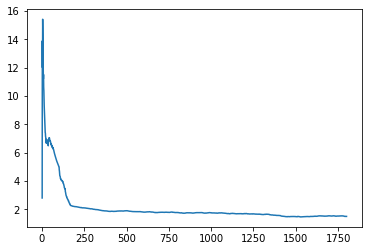

validation accuracy : 0.49369436201780414


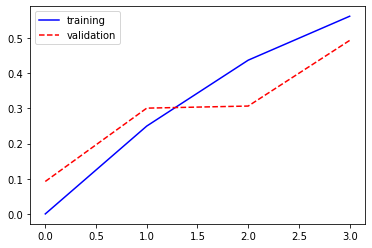

In [0]:
if __name__ == '__main__': #https://discuss.pytorch.org/t/brokenpipeerror-errno-32-broken-pipe-when-i-run-cifar10-tutorial-py/6224/4   
    torch.manual_seed(0)
    np.random.seed(0)
    torch.cuda.manual_seed(0)
    random.seed(0)
    print("pytorch version", torch.__version__)
    criteria = torch.nn.CrossEntropyLoss()
    net = Load_model()
    train_loader, val_loader =Load_data()
    net=net.cuda()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
    net = train(net, train_loader, val_loader, criteria, optimizer, epochs, scheduler)
    #test_loader=torch.utils.data.DataLoader(test_loader,batch_size=128)
    #test_accuracy = test(net, test_loader)
    #print('Test Accuracy: {}'.format(test_accuracy))       
